# Pop Up Shop

![](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c5/Weich_Couture_Alpaca%2C_D%C3%BCsseldorf%2C_December_2020_%2809%29.jpg/1200px-Weich_Couture_Alpaca%2C_D%C3%BCsseldorf%2C_December_2020_%2809%29.jpg)

Kürschner (talk) 17:51, 1 December 2020 (UTC), CC0, via Wikimedia Commons

## The Problem

You've been offered an opportunity to operate a pop-up shop for events occuring at a famous location. For each event you'll be selling an item unique item. The items you would be selling costs &euro;5 each and you will be able to sell them for 20&euro;. But if they don't sell during the event then you will receive only 2 for each item returned to the supplier.

| Parameter | Symbol | Value |
| :---: | :---: | :---: |
| sales price | $r$ | &euro;20 |
| unit cost | $c$ | &euro;5 |
| salvage value | $w$ | &euro;2 |

It is clear the more you sell the more profit you will earn. Demand for these items, however, will be high only if the weather is good. Historical data suggests typical scenarios.

| Scenario ($s$) | Demand ($D_s$) | Probability ($p_s$) |
| :---: | :-----: | :----------: |
| Sunny Skies | 500 | 0.25 |
| Good Weather | 400 | 0.50 |
| Poor Weather | 200 | 0.25 |

The ordering dilemma, of course, is that the weather won't be known until after the order is placed. Order enough items to meet demand for a good weather day results in a  financial penalty on returned goods if the weather is poor. But ordering just enough to satisfy the demand on a poor weather day leaves "money on the table" for good weather days.

What choice would you make?

One possibility to order enough to meet expected demand. The expected demand is given by

\begin{align*}
\mathbb E[D] & = \sum_{s} p_s D_s \\
& = 0.25\times 500 + 0.5\times 400 + 0.25\times 200 \\
& = 375
\end{align*}

A spreadsheet analysis shows an average profit of &euro;5,052 and no scenario shows a loss. This would appear to be a satisfactory outcome.

| Scenario ($s$) | Demand ($D_s$) | Probability ($p_s$) | Ordered ($x$) | Sold ($y_s$) | Salvage ($x - y_s$) | Profit ($f_s$) |
| :---: | :-----: | :----------: | :---: | :---: | :---: | :---: | 
| Sunny Skies | 500 | 0.30 | 380 | 380 | 0 | &euro;5,700 |
| Good Weather | 350 | 0.60 | 380 | 350 | 30 | &euro;5,160 |
| Poor Weather | 200 | 0.10 | 380 | 200 | 175 | &euro;2,460 |
| **Average** | **375** | | | | | **&euro;5,052** |

Can we find an order resulting in a higher expected profit?

## A Model to Maximize Expected Profit

Given the variables defined in the table above, the profit $f_s$ for scenario $s$ is 

$$f_s = \underbrace{r y_s}_\text{sales revenue} + \underbrace{w (D_s - y_s)}_\text{salvage value} - \underbrace{c x}_\text{order cost}$$

The expected profit $\mathbb E[f]$ is given by

\begin{align*}
\mathbb E[f] & = \sum_s p_s f_s
\end{align*}

Operationally, $y_s$ can be no larger the number of items ordered, $x$, or the demand under scenario $s$, $D_s$. Putting this together, the problem to be solved is

\begin{align*}
& \max_{x, y_s} \mathbb E[f] = \sum_{s\in S} p_s f_s \\
\text{subject to} \\
f_s & = r y_s + w(D_s - y_s) - c x & \forall s \in S\\
y_s & \leq x & \forall s \in S \\
y_s & \leq D_s & \forall s \in S
\end{align*}

where $x$ is a non-negative number representing the number of items that will be ordered, and the non-negative variable $y_s$ refers the number of items sold in scenario $s$ in the set $S$ comprising all scenarios under consideration.

## Coding the Model in Pyomo

In [1]:
import sys
at_colab = "google.colab" in sys.modules

if at_colab:
    _=!pip install -q pyomo
    _=!wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
    _=!unzip -o -q ipopt-linux64
    _=!apt-get install -y -q coinor-cbc
    _=!pip install -q cplex
    _=!pip install -q gurobipy
    _=!pip install -q xpress

We begin by encoding the problem data using standard Python objects. The scenario information is stored as nested dictionary ... a commonly used technique in Python to store structured data. Here each scenario is represented by a descriptive key. In turn, the value of each scenario is a dictionary with keys labeling the demand and probability.

In [2]:
# price information
r = 20
c = 12
w = 2

# scenario information
scenarios = {
    "sunny skies" : {"demand": 500, "p": 0.30},
    "good weather": {"demand": 350, "p": 0.60},
    "poor weather": {"demand": 200, "p": 0.10},
}

In [51]:
import pyomo.environ as pyo
solver = pyo.SolverFactory('cbc')

# create model instance
pm = pyo.ConcreteModel('Pop-up Shop')

# decision variables
pm.x = pyo.Var(within=pyo.NonNegativeReals)
pm.y = pyo.Var(scenarios, within=pyo.NonNegativeReals)
pm.f = pyo.Var(scenarios)

# objective
pm.expected_profit = pyo.Objective(expr=sum([scenarios[s]["p"]*pm.f[s] for s in scenarios.keys()]), 
                                   sense=pyo.maximize)

# constraints
pm.constraints = pyo.ConstraintList()
for s in scenarios.keys():
    pm.constraints.add(pm.f[s] == r*pm.y[s] + w*(scenarios[s]["demand"] - pm.y[s]) - c*pm.x)
    pm.constraints.add(pm.y[s] <= pm.x)
    pm.constraints.add(pm.y[s] <= scenarios[s]["demand"])

pm.pprint()

3 Set Declarations
    constraints_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    9 : {1, 2, 3, 4, 5, 6, 7, 8, 9}
    f_index : Size=1, Index=None, Ordered=False
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'good weather', 'poor weather', 'sunny skies'}
    y_index : Size=1, Index=None, Ordered=False
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'good weather', 'poor weather', 'sunny skies'}

3 Var Declarations
    f : Size=3, Index=f_index
        Key          : Lower : Value : Upper : Fixed : Stale : Domain
        good weather :  None :  None :  None : False :  True :  Reals
        poor weather :  None :  None :  None : False :  True :  Reals
         sunny skies :  None :  None :  None : False :  True :  Reals
    x : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :

In [45]:
expected_demand = sum([scenarios[s]["p"]*scenarios[s]["demand"] for s in scenarios.keys()])
print(f"Expected Demand = {expected_demand}")
print(f"Order size = {pm.x():0.1f} units")
print(f"Expected Profit = {pm.expected_profit():0.2f}\n")
print("Scenario      Probabilty  Demand  Order  Sales Salvage   Profit")
for s in scenarios.keys():
    p = scenarios[s]['p']
    D = scenarios[s]['demand']
    print(f"{s:12s}        {p:0.2f}     {pm.x():3.0f}    {D:3.0f}  {pm.y[s]():5.0f}   {D - pm.y[s]():5.0f}  {pm.f[s]():5.2f}")

Expected Demand = 380.0
Order size = 350.0 units
Expected Profit = 2590.00

Scenario      Probabilty  Demand  Order  Sales Salvage   Profit
sunny skies         0.30     350    500    350     150  3100.00
good weather        0.60     350    350    350       0  2800.00
poor weather        0.10     350    200    200       0  -200.00


In [4]:
print(popup.expected_profit())
print(popup.x())
for s in scenarios.keys():
    print(popup.y[s]())

NameError: name 'popup' is not defined

In [97]:
import numpy as np


# expected demand
x = np.sum([s["p"]*s["demand"] for key, s in scenarios.items()])
print(f"Expected Demand = {x:0.1f} units\n")

for key, s in scenarios.items():
    y = min(s["demand"], x)
    s["y"] = y
    s["profit"] = r*y + w*(x-y) -  c*x
    print(f"{key} profit = {s['profit']:0.2f}")
    
expected_profit = np.sum([s["p"]*s["profit"] for key, s in scenarios.items()])
print(f"\nExpected Profit = {expected_profit:0.2f}")

Expected Demand = 380.0 units

sunny skies profit = 3040.00
good weather profit = 2500.00
poor weather profit = -200.00

Expected Profit = 2392.00


## Background

## Solution

In [1]:
%%script glpsol -m /dev/stdin

# Example: Newsvendor.mod

/* Unit Price Data */
param r >= 0;                              # Price
param c >= 0;                              # Cost
param w >= 0;                              # Salvage value

/* Price data makes sense only if  Price > Cost > Salvage */
check: c <= r;
check: w <= c;

/* Probabilistic Demand Forecast */
set SCENS;                                 # Scenarios
param D{SCENS} >= 0;                       # Demand
param Pr{SCENS} >= 0;                      # Probability

/* Probabilities must sum to one. */
check: sum{k in SCENS} Pr[k] = 1;

/* Expected Demand */
param ExD := sum{k in SCENS} Pr[k]*D[k];

/* Lower Bound on Profit: Expected Value of the Mean Solution */
param EVM := -c*ExD + sum{k in SCENS} Pr[k]*(r*min(ExD,D[k])+w*max(ExD-D[k],0));

/* Upper Bound on Profit: Expected Value with Perfect Information */
param EVPI := sum{k in SCENS} Pr[k]*(r-c)*D[k];

/* Two Stage Stochastic Programming */
var x >= 0;                     # Stage 1 (Here and Now): Order Quqntity
var y{SCENS}>= 0;               # Stage 2 (Scenario Dep): Actual Sales
var ExProfit;                   # Expected Profit

/* Maximize Expected Profit */
maximize OBJ: ExProfit;

/* Goods sold are limited by the order quantities and the demand  */
s.t. PRFT: ExProfit = -c*x + sum{k in SCENS} Pr[k]*(r*y[k] + w*(x-y[k]));
s.t. SUPL {k in SCENS}: y[k] <= x;
s.t. DMND {k in SCENS}: y[k] <= D[k];

solve;

table Table_EVM {k in SCENS} OUT "CSV" "evm.csv" "Table":
   k~Scenario,
   Pr[k]~Probability, 
   D[k]~Demand, 
   ExD~Order, 
   min(ExD,D[k])~Sold,
   max(ExD-D[k],0)~Salvage, 
   -c*ExD + r*min(ExD,D[k]) + w*max(ExD-D[k],0)~Profit;
   
table Table_EVPI {k in SCENS} OUT "CSV" "evpi.csv" "Table":
   k~Scenario,
   Pr[k]~Probability, 
   D[k]~Demand, 
   D[k]~Order, 
   D[k]~Sold,
   0~Salvage, 
   -c*D[k] + r*D[k]~Profit;
   
table Table_SP {k in SCENS} OUT "CSV" "evsp.csv" "Table":
   k~Scenario,
   Pr[k]~Probability, 
   D[k]~Demand, 
   x~Order, 
   y[k]~Sold,
   x-y[k]~Salvage, 
   -c*x + r*y[k] + w*(x-y[k])~Profit;

data;

/* Problem Data corresponds to a hypothetical case of selling programs prior 
to a home football game. */

param r := 10.00;                         # Unit Price
param c :=  6.00;                         # Unit Cost
param w :=  2.00;                         # Unit Salvage Value

param: SCENS:  Pr    D   :=
       HiDmd   0.25  250
       MiDmd   0.50  125
       LoDmd   0.25   75 ;

end;

GLPSOL: GLPK LP/MIP Solver, v4.52
Parameter(s) specified in the command line:
 -m /dev/stdin
Reading model section from /dev/stdin...
Reading data section from /dev/stdin...
/dev/stdin:86: warning: final NL missing before end of file
86 lines were read
Checking (line 10)...
Checking (line 11)...
Checking (line 19)...
Generating OBJ...
Generating PRFT...
Generating SUPL...
Generating DMND...
Model has been successfully generated
GLPK Simplex Optimizer, v4.52
8 rows, 5 columns, 15 non-zeros
Preprocessing...
3 rows, 4 columns, 6 non-zeros
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 3
*     0: obj =   0.000000000e+00  infeas =  0.000e+00 (0)
*     5: obj =   4.000000000e+02  infeas =  0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0.1 Mb (142439 bytes)
Writing Table_EVM...
Writing Table_EVPI...
Writing Table_SP...
Model has been succes

### Expected Value for the Mean Scenario (EVM)

In [2]:
import pandas
evm = pandas.read_csv("evm.csv")
display(evm)

ev_evm = sum(evm['Probability']*evm['Profit'])
print "Expected Value for the Mean Scenario = {:6.2f}".format(ev_evm)

,Scenario,Probability,Demand,Order,Sold,Salvage,Profit
0,HiDmd,0.25,250,143.75,143.75,0.00,575
1,MiDmd,0.50,125,143.75,125.00,18.75,425
2,LoDmd,0.25,75,143.75,75.00,68.75,25


Expected Value for the Mean Scenario = 362.50


### Expected Value with Perfect Information (EVPI)

In [3]:
evpi = pandas.read_csv("evpi.csv")
display(evpi)

ev_evpi = sum(evpi['Probability']*evpi['Profit'])
print "Expected Value with Perfect Information = {:6.2f}".format(ev_evpi)

,Scenario,Probability,Demand,Order,Sold,Salvage,Profit
0,HiDmd,0.25,250,250,250,0,1000
1,MiDmd,0.50,125,125,125,0,500
2,LoDmd,0.25,75,75,75,0,300


Expected Value with Perfect Information = 575.00


### Expected Value by Stochastic Programming

In [4]:
evsp = pandas.read_csv("evsp.csv")
display(evsp)

ev_evsp = sum(evsp['Probability']*evsp['Profit'])
print "Expected Value by Stochastic Programming = {:6.2f}".format(ev_evsp)

,Scenario,Probability,Demand,Order,Sold,Salvage,Profit
0,HiDmd,0.25,250,125,125,0,500
1,MiDmd,0.50,125,125,125,0,500
2,LoDmd,0.25,75,125,75,50,100


Expected Value by Stochastic Programming = 400.00


### Value of Perfect Information

In [5]:
print "Value of Perfect Information = {:6.2f}".format(ev_evpi-ev_evsp)

Value of Perfect Information = 175.00


### Value of the Stochastic Solution

In [6]:
print "Value of the Stochastic Solution = {:6.2f}".format(ev_evsp-ev_evm)

Value of the Stochastic Solution =  37.50


In [30]:
r = 1.00
c = 0.60
w = 0.25

def profit(D,x):
    return r*min([D,x]) + w*max([0,x-D]) - c*x

In [31]:
scenarios = [['Low Demand',75,.25],['High Demand',200,.75]]

In [33]:
def exprofit(x):
    v = 0
    for s in scenarios:
        v += s[2]*profit(s[1],x)
    return profit

x = linspace(0,400,400)
exprofit(100)


<function __main__.profit>

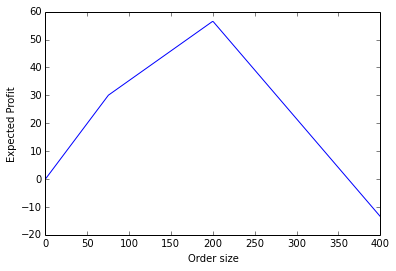

In [23]:
x = linspace(0,400,400)
plot(x,map(exprofit,x))
xlabel('Order size')
ylabel('Expected Profit')

